In [12]:
import torch
import triton, triton.language as tl, triton_util as tu
cdiv = tu.cdiv
from kernel_axis1_clean import forward_kernel

In [20]:
dtype = torch.float16

pz = 10 # pack size

m,r,n = 256,32,128  # size, out, lora rank, in
gz,gz2  = 64,128    # group size, group size for quanting zero & scale, pack size

bsb,bsm,bsr,bsn=16,16,16,16

assert n%gz==0 and m%gz2==0, f'group_size ({gz}) needs to divide n ({n}); and group_size_2 ({gz2}) needs to divide m ({m})'

In [21]:
def rand(*shapes): return torch.randn(*shapes, dtype=dtype, device='cuda')
def zeros(*shapes): return torch.zeros(*shapes, dtype=dtype, device='cuda')

In [22]:
# hqq uses torch.compile, which doesn't work with triton 3.0.0, so can't use from hqq.core.quantize.HQQLinear
# instead, quantized ourselves, and use hqq for packing

# from our hqq reference implementation (`pythoin_hqq_qdora_v2.ipynb`), slightly adapted:
from hqq.core.bitpack import BitPack

def _quant(data, gz, axis, bits, packed):
    assert data.numel()%gz==0, f'group_size {gz} must divide data (numel = {data.numel()})'
    assert axis in (0,1), 'pass axis == 0 or 1'
    data = data.float().reshape(-1,gz) if axis==1 else data.float().reshape(gz,-1)
    min_, max_ = data.min(axis=axis, keepdim=True).values, data.max(axis=axis, keepdim=True).values
    scale = (2**bits-1) / (max_-min_) # note: hqq clamp to 2e4 to avoid half-precision problems, let's ignore that for now
    zero = -min_ * scale
    data = (data * scale + zero).round()
    if packed: data = BitPack.pack_3bit_32(data)
    return data, zero, 1/scale # invert scale, so in dequanting we multiply instead of divide

def quant(data, gz, gz2, bits=3):
    qdata,  zero,   scale = _quant(data,  gz,  axis=1, bits=bits, packed=True)
    qzero,  zzero, zscale = _quant(zero,  gz2, axis=0, bits=bits, packed=False)
    qscale, szero, sscale = _quant(scale, gz2, axis=0, bits=bits, packed=False)
    return qdata, qzero, qscale, zzero, zscale, szero, sscale

In [25]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['batch_size'], x_vals=[2**i for i in range(5, 12, 1)], x_log=True,
        line_arg='method', line_vals=['pytorch', 'triton'], line_names=['PyTorch', 'Triton'], styles=[('blue', '-'), ('green', '-')],
        ylabel='ms',
        plot_name='hqq-qdora forward',
        args=dict(m=m,r=r,n=n, gz=gz, gz2=gz2, bsb=bsb,bsm=bsm,bsr=bsr,bsn=bsn), # Values for function arguments not in `x_names` and `y_name`. -- todo: pass kernel function?
    ))
def benchmark(batch_size, m,r,n, gz,gz2, bsb,bsm,bsr,bsn, method):
    b = batch_size    
    X, A, B = rand(b,n), rand(r,n) * 0.1, rand(m,r) * 0.1
    mag = rand(m).abs()
    α = rand(1).item()
    W = rand(m,n)
    W_qp, zero_q, scale_q, zzero, zscale, szero, sscale = quant(W, gz=gz, gz2=gz2)
    ng2 = m*n//(gz*gz2)
    assert (scale_q.shape, zero_q.shape, sscale.shape, szero.shape, zscale.shape, zzero.shape) == ((gz2, ng2), (gz2, ng2), (1, ng2), (1, ng2), (1, ng2), (1, ng2))
    
    Y = zeros(b,m)
    W_tmp = zeros(bsm,n)
    tu.assert_tensors_gpu_ready(Y, X, A, B, W_qp, mag, scale_q, zero_q, sscale, szero, zscale, zzero, W_tmp)
    grid = (cdiv(b, bsb), cdiv(m, bsm))
    
    quantiles = [0.5, 0.2, 0.8]    
    if method == 'pytorch':      ms, min_ms, max_ms = triton.testing.do_bench(lambda: α*mag[None,:]*(X@W.t() + X@A.t()@B.t())/((W+B@A)**2).sum(axis=1).sqrt()[None,:], quantiles=quantiles)
    if method == 'triton':       ms, min_ms, max_ms = triton.testing.do_bench(lambda: forward_kernel[grid](
        X, A, B, W_qp, scale_q, zero_q,  # input matrices
        mag, sscale, szero, zscale, zzero, # input vectors
        α, # input scalars
        Y, # output matrix
        b,m,r,n,# dimensions
        gz, gz2, pz, # grouping / packing configs
        bsb, bsm, bsr, bsn, # block sizes
        # todo umer: add? # strides
        W_tmp, # todo umer: should not need this # intermediate matrices
    ), quantiles=quantiles)
    
    return ms, max_ms, min_ms

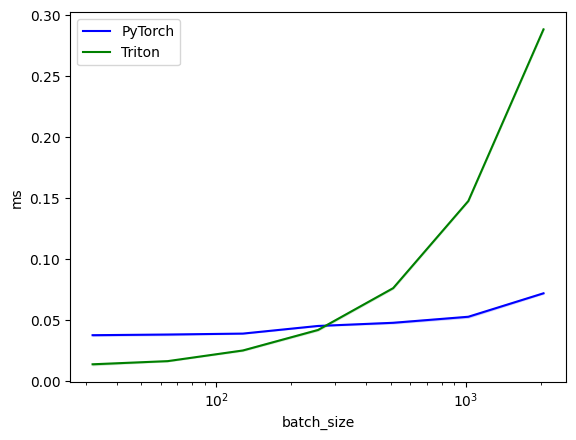

hqq-qdora forward:
   batch_size   PyTorch    Triton
0        32.0  0.037664  0.013792
1        64.0  0.038208  0.016384
2       128.0  0.038976  0.025120
3       256.0  0.045248  0.041952
4       512.0  0.047840  0.076288
5      1024.0  0.052800  0.147776
6      2048.0  0.072032  0.288624


In [26]:
benchmark.run(print_data=True, show_plots=True)